# Handling Missing Values

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

In this notebook we will discuss some techniques that can be used to deal with missing values in **tabular data**. We will go from most basic to most complicated. 
Note that just because one method is more complicated, does not mean it will perform better. Always test everything in your cross-validation scheme and choose the best method. Not necessarily what you think is the most complicated.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

import warnings
warnings.filterwarnings("ignore")

import pathlib
cwd = pathlib.Path.cwd()
DATASET_PATH = cwd.parents[2] / "data" / "song-popularity-prediction"
print(DATASET_PATH)

/Users/particle1331/code/inefficient-networks/data/song-popularity-prediction


```{margin}
⚠️ **Attribution:** These are notes on the video [Handling Missing Values](https://www.youtube.com/watch?v=EYySNJU8qR0) by [GM Rob Mulla](https://www.kaggle.com/robikscube). Here, I used XGBoost instead of LightGBM.
```

Loading the train and test sets:

In [2]:
train = pd.read_csv(DATASET_PATH / "train.csv")
test = pd.read_csv(DATASET_PATH /  "test.csv")
ss = pd.read_csv(DATASET_PATH / "sample_submission.csv")

# Add indicator column so we can combine all data in a single df
train["is_train"] = True
test["is_train"] = False
tt = pd.concat([train, test]).reset_index(drop=True).copy()

print(train.shape, test.shape, tt.shape)

(40000, 16) (10000, 15) (50000, 16)


In [3]:
tt.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,is_train
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0.0,True
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1.0,True
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0.0,True
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0.0,True
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0.0,True


In [4]:
tt.tail()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,is_train
49995,9995,196204.0,0.083936,0.823252,0.442246,0.002990,1.0,0.123921,-8.682195,1,0.041171,98.264618,4,0.784104,NaN,False
49996,9996,218343.0,0.105279,0.683743,0.848627,0.001911,6.0,0.106522,-4.946250,0,0.033605,103.949646,4,0.850754,NaN,False
49997,9997,188434.0,0.753472,0.783947,0.498261,0.134027,6.0,0.088147,-11.812606,1,0.029526,119.090558,4,0.482961,NaN,False
49998,9998,173044.0,0.863579,0.373283,0.476142,0.000049,10.0,0.122122,-12.371232,0,0.190628,103.048349,3,0.518742,NaN,False
49999,9999,157896.0,0.019852,0.720380,NaN,0.037727,2.0,0.139422,-4.965311,1,0.053257,109.873611,4,0.971368,NaN,False


We will perform some analysis on the dataset as a whole.

## Why are there missing values?

Before starting with missing value imputation, we should ask why missing values are there. It could be that values are randomly missing, or the fact that they are missing can be used as a feature to improve your models. Example causes of missing data:
* Sensor data where the sensor went offline.
* Survey data where some questions were not answered.
* A Kaggle competition where the host wants to make the problem hard :D

You need to understand Why you have missing values before deciding on the approach for dealing with them.


### Missing values per feature

What are the counts of missing values in train vs. test set?

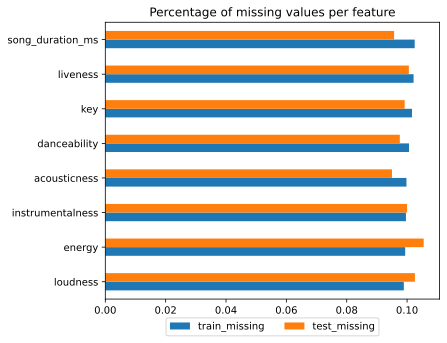

In [5]:
ncounts = pd.DataFrame([train.isna().mean(), test.isna().mean()]).T
ncounts = ncounts.rename(columns={0: "train_missing", 1: "test_missing"})
ncounts.query("(train_missing > 0) or (test_missing > 0)").sort_values("train_missing").plot(
    kind="barh", figsize=(6, 5), title="Percentage of missing values per feature"
)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=5)
plt.show()

Note that percentage of missing values are all around 10%. It's likely that these are dropped on purpose. Or there are systematic reasons why these values are missing. 

In [6]:
nacols = list(ncounts.query("(train_missing > 0) or (test_missing > 0)").index)
nacols

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness']

### Missing values per observation

How many missing values per observation?

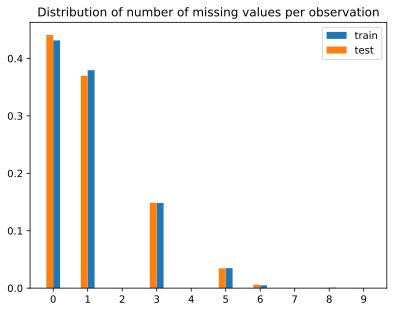

In [7]:
tt["n_missing"] = tt[nacols].isna().sum(axis=1)

train_hist = np.histogram(tt.query("is_train == True").n_missing)[0] / len(train)
test_hist = np.histogram(tt.query("is_train == False").n_missing)[0] / len(test)
x = np.arange(len(train_hist))

plt.bar(x + 0.1, train_hist, width=0.2, label='train')
plt.bar(x - 0.1, test_hist,  width=0.2, label='test')
plt.xticks(x)
plt.title("Distribution of number of missing values per observation")
plt.legend();

In [8]:
tt.query("n_missing == 6")

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,is_train,n_missing
13457,13457,176401.0,NaN,NaN,0.833408,NaN,NaN,NaN,NaN,0,0.052580,142.802779,3,0.546615,0.0,True,6
19697,19697,NaN,NaN,NaN,NaN,0.003014,NaN,NaN,-10.708472,0,0.035591,95.181833,3,0.483101,0.0,True,6
48594,8594,NaN,NaN,NaN,0.344299,NaN,2.0,NaN,NaN,1,0.035495,151.125383,4,0.463903,NaN,False,6


Samples with high number of missing values will be difficult to impute. 

### Missing distribution by feature value

If number of missing value per observation is heavily biased towards a certain feature value, we can conclude that that feature value is somehow associated with an observation having overall missing features count. We do this for categorical features and the target.

In [9]:
for col in ['audio_mode', 'key', 'song_popularity']:
    print(f'{col:<20} {(tt.groupby(col)["n_missing"].mean()).min():.4f} - {(tt.groupby(col)["n_missing"].mean()).max():.4f}')

audio_mode           0.7997 - 0.8045
key                  0.6737 - 0.7483
song_popularity      0.7997 - 0.8075


Let's check the `key` column since it has significant range.

In [10]:
# create missing indicator columns
tt2 = tt.copy()
for col in nacols:
    tt2[col + '_isna'] = tt2[col].isna()

# check variance of percentage of missing values wrt to key values
tt2.groupby('key')[[col + '_isna' for col in nacols]].mean().std().sort_values()

key_isna                 0.000000
song_duration_ms_isna    0.003608
acousticness_isna        0.003937
danceability_isna        0.005062
liveness_isna            0.005803
loudness_isna            0.006298
instrumentalness_isna    0.008514
energy_isna              0.012107
dtype: float64

Let's check missing `energy` per `key` value:

In [11]:
tt2.groupby('key')['energy_isna'].agg(["mean", "count"])

,mean,count
key,,
0.0,0.096195,6518
1.0,0.110524,2651
2.0,0.096906,5139
3.0,0.103062,1698
4.0,0.102195,2779
5.0,0.100162,3694
6.0,0.101695,6195
7.0,0.103346,3377
8.0,0.090400,3750


Note that while `key == 11` has significant difference in percentage of missing `energy`, it has the least count. Hence, the relationship between having a key of 11 and having a missing energy feature may not be truly significant. In case there is actual difference, then the imputation method should take into account the value of this feature (see group-by filling below).

## Basics of missing value imputation

In this section, we outline some of the first things to consider when handling missing data.

### Preprocessing: adding missing value indicators

We will add a missing value indicator for each feature. If missing data does not occur completely at random, "missing" itself should have information. Thus, adding missing flags for some features can improve model performance.


In [12]:
# Create indicator df
tt_missing_tag_df = tt[nacols].isna()
tt_missing_tag_df.columns = [f"{c}_missing" for c in tt_missing_tag_df.columns]

# Concat to original df
tt = pd.concat([tt, tt_missing_tag_df], axis=1)

### Protip: Predicting target using only missing value indicators as features

In [13]:
tt.query("is_train == True").song_popularity.value_counts()

0.0    25424
1.0    14576
Name: song_popularity, dtype: int64

In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

lr = LogisticRegressionCV(scoring="accuracy", cv=5) # StratifiedKFold by default
X = tt.query("is_train == 1")[[col+"_missing" for col in nacols]]
y = tt.query("is_train == 1").song_popularity

# Fit model + predict
lr.fit(X, y)
preds = lr.predict_proba(X)[:, 0]
print("ROC-AUC:", roc_auc_score(y, preds))

ROC-AUC: 0.4928022710677621


This shows that missing indicators by themselves are not predictive of the target.

### Basic techniques for filling missing values

**Do nothing.** Tree-based models like LightGBM and XGBoost can work with missing values. Other types of regression or neural networks will require some sort of imputation. Thus, one way to handle missing values is to simply use models that can treat missing values as features without any preprocessing.

* https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html


In [15]:
import lightgbm as lgb

# use_missing=True (default) or zero_as_missing=False (convert NA to 0) are params that can be used
lgbm_params = {
    'objective': 'regression',
    'metric': 'auc',
    'verbose': -1,
    'boost_from_average': False,
    'min_data': 1,
    'num_leaves': 2,
    'learning_rate': 1,
    'min_data_in_bin': 1,
    'use_missing': False,
    'zero_as_missing': True
}

model = lgb.LGBMClassifier(params=lgbm_params)

**Drop them.** Another technique is to simply drop observations with missing features. This  doesn't work on the test set since we have to somehow impute missing values to make a prediction. We can also drop whole columns. But this leaves us less features to work with during modelling.

In [16]:
# Dropping observations
print(tt.shape, tt.dropna(axis=0).shape)

# We can also drop on particular features
print(tt.shape, tt.dropna(axis=0, subset=['song_duration_ms']).shape)

(50000, 25) (17259, 25)
(50000, 25) (44942, 25)


In [17]:
# Dropping whole features
tt.shape, tt.dropna(axis=1).shape

((50000, 25), (50000, 16))

**Pandas imputation.** The Pandas library offer table-based functionalities for dealing with missing data. For instance, we can use Pandas `.fillna` as an easy way to fill missing values with arbitrary values.

In [18]:
# Fill with a default value
tt['song_duration_ms'].fillna(-999).head(5)

0    212990.0
1      -999.0
2    193213.0
3    249893.0
4    165969.0
Name: song_duration_ms, dtype: float64

```{margin}
For categorical variables, instead of the mean or median, we can use the most frequent value as `fill_value`.
```

In [19]:
# Impute with mean (fixed)
fill_value = tt["song_duration_ms"].mean() # or median
tt["song_duration_ms_mean_imp"] = tt["song_duration_ms"].fillna(fill_value)

# Printing
tt.loc[tt['song_duration_ms'].isna()][["song_duration_ms", "song_duration_ms_mean_imp"]].head(5)

,song_duration_ms,song_duration_ms_mean_imp
1,NaN,193150.809021
13,NaN,193150.809021
14,NaN,193150.809021
15,NaN,193150.809021
28,NaN,193150.809021


**Filling based on feature value.** Here we impute using the average value of a feature over a group based on another feature. As an example we will use the `audio_mode` feature to group observations, where we will base our mean imputation for the `song_duration` feature.

In [ ]:
sd_mean_map = tt.groupby("audio_mode")["song_duration_ms"].mean().to_dict()
sd_mean_map # song_duration mean per audio mode value.

{0: 193860.63699819762, 1: 191649.42961114578}

In [ ]:
sd_mean_series = tt['audio_mode'].map(sd_mean_map) # imputer if missing
tt["song_duration_ms_mean_audio_mode"] = tt["song_duration_ms"].fillna(sd_mean_series)

Let's check for observations with missing `song_duration`:

In [ ]:
tt.query('song_duration_ms_missing == True')[['audio_mode','song_duration_ms_mean_audio_mode']].head(5)

,audio_mode,song_duration_ms_mean_audio_mode
1,1,191649.429611
13,0,193860.636998
14,0,193860.636998
15,0,193860.636998
28,0,193860.636998


## Time-series data

For time-series data, we can fill with the previous or next value in the column. Make sure that the data has been sorted before making this imputation. 

In [20]:
t = np.linspace(0, 2*np.pi, 20)
x = np.sin(t)
ts_data = pd.DataFrame(index=t)
ts_data["data"] = x

# Randomly drop data
ts_data["data_missing"] = ts_data["data"].sample(frac=0.9, random_state=42)

# Fill with different methods
ts_data["data_ffill"] = ts_data["data_missing"].ffill()
ts_data["data_bfill"] = ts_data["data_missing"].bfill()
ts_data["data_mfill"] = 0.5 * (ts_data["data_ffill"] + ts_data["data_bfill"])
ts_data["data_mean_fill"] = ts_data["data_missing"].fillna(ts_data["data_missing"].mean())

Note that `ffill` pushes previous data to missing data, while `bfill` pulls next future data to missing data. Filling with the average of the two smooths the curve out as shown above. Also, note that the mean of the data is zero, since the sine curve completes two rotations.

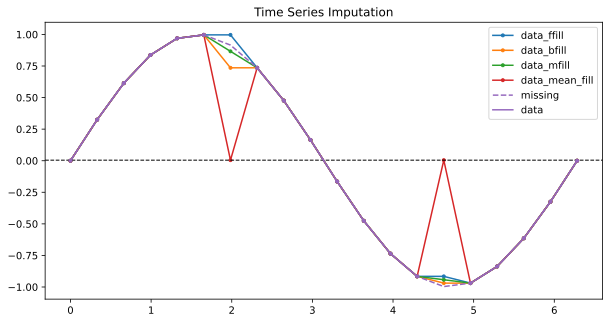

In [21]:
ts_data.drop(["data", "data_missing"], axis=1).plot(style=".-",
    figsize=(10, 5),
    title='Time Series Imputation')

# Plot mean of data
plt.axhline(ts_data["data_missing"].mean(), color='k', linestyle='--', linewidth=1.0)

# Plot data
plt.plot(ts_data.data, linestyle="--", color="C4", label="missing")
plt.plot(ts_data.data_missing, linestyle="solid", color="C4", label="data")
plt.scatter(t, ts_data.data_missing.values, color="C4", s=10, zorder=2)

plt.legend()
plt.show()

## Model-based imputation

Model-based imputers train on the dataset to find the missing values to impute. First, we will use imputers in the `scikit-learn` library, then we will look at an XGBoost-based imputer. Using `scikit-learn` is good because it provides a fit and transform method. This allows us to fit on the training and transform on both the train validation. This also allows us to create pipelines. In real world situations you will want to fit and transform within your cross validation loop to ensure no leakage.

**Protip:** In kaggle competitions we sometimes know all of the features for the test set. So it may be advantageous to fit on all the data. This is analogous to refitting on the validation set before rolling out the final estimators. This doesn't work for code competitions because we can't see the test data before out model predicts.





### `SimpleImputer`

This allows us to:
* Impute with the mean value, median, and just a single value
* `add_indicator` will add the indicator column


In [1]:
FEATURES = [
    "song_duration_ms",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "audio_mode",
    "speechiness",
    "tempo",
    "time_signature",
    "audio_valence",
]

Testing:

In [26]:
from sklearn.impute import SimpleImputer

# Initialize mean imputer. No need to add indicator when transforming.
imputer = SimpleImputer(strategy="mean", add_indicator=False)

# Fit + transform `song_duration`.
train_column = train['song_duration_ms'].values.reshape(-1, 1)
imputer.fit(train_column)

# Looking at result:
print("mean:", train['song_duration_ms'].mean())
pd.DataFrame([train_column.reshape(-1), imputer.transform(train_column).reshape(-1)], index=['data', 'transformed_data']).T.head(5)

mean: 193165.84757235576


,data,transformed_data
0,212990.0,212990.000000
1,NaN,193165.847572
2,193213.0,193213.000000
3,249893.0,249893.000000
4,165969.0,165969.000000


Note that `SimpleImputer` can be applied on the entire feature set to simultaneously fit on each column.

In [27]:
# Fit / Transform on train, transform only on val / test
imputer = SimpleImputer(strategy="mean", add_indicator=False)
train_imputed = imputer.fit_transform(train[FEATURES])
test_imputed = imputer.transform(test[FEATURES])

# Note that `transform` returns an array, so we have to reconstruct.
print("No. missing:", pd.DataFrame(train_imputed).isna().sum().sum())
pd.DataFrame(train_imputed, columns=FEATURES).head()

No. missing: 0


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.0,0.198514,-5.619088,0.0,0.082570,158.386236,4.0,0.734642
1,193165.847572,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1.0,0.127358,102.752988,3.0,0.711531
2,193213.000000,0.276404,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0.0,0.052282,178.685791,3.0,0.425536
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0.0,0.035618,128.715630,3.0,0.453597
4,165969.000000,0.493017,0.570951,0.740982,0.002033,10.0,0.094891,-2.684095,0.0,0.050746,121.928157,4.0,0.741311


In [28]:
# For kaggle competition you can kind of cheat by fitting on all data
tt_imputed = imputer.fit_transform(tt[FEATURES])

tt_simple_imputed = pd.DataFrame(tt_imputed, columns=FEATURES)
tt_simple_imputed.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.0,0.198086,-5.619088,0.0,0.082570,158.386236,4.0,0.734642
1,193150.809021,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1.0,0.127358,102.752988,3.0,0.711531
2,193213.000000,0.277183,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0.0,0.052282,178.685791,3.0,0.425536
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0.0,0.035618,128.715630,3.0,0.453597
4,165969.000000,0.493017,0.570724,0.740982,0.002033,10.0,0.094891,-2.684095,0.0,0.050746,121.928157,4.0,0.741311


### `IterativeImputer`

Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. Uses by default the `BayesianRidge` model to impute.

* https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [29]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

**Protip:** We want to fit and predict on all columns! This is because the model is using all features to help fill the missing values.


In [30]:
%%time
it_imputer = IterativeImputer(max_iter=10)

train_iter_imputed = it_imputer.fit_transform(train[FEATURES])
test_iter_imputed = it_imputer.transform(test[FEATURES])
tt_iter_imputed = it_imputer.fit_transform(tt[FEATURES])

# Create train test imputed dataframe
tt_iter_imputed_df = pd.DataFrame(tt_iter_imputed, columns=FEATURES)

CPU times: user 1min 13s, sys: 7.15 s, total: 1min 20s
Wall time: 13.1 s


In [31]:
# Save this off to use later
tt_iter_imputed_df.to_parquet(DATASET_PATH / "tt_iterative_imputed.parquet")

### `KNNImputer`

This imputation method uses k-Nearest Neighbors. Each sample's missing values are imputed using the mean value from `n_neighbors` nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close. Note that, as usual with KNN-based methods, this can be slow.

* https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html


In [32]:
%%time
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=1)

train_knnimputed = knn_imputer.fit_transform(train[FEATURES])
test_knnimputed = knn_imputer.transform(test[FEATURES])
tt_knnimputed = knn_imputer.fit_transform(tt[FEATURES])
tt_knnimputed = pd.DataFrame(tt_knnimputed, columns=FEATURES)

# Create KNN Train/Test imputed dataframe
knn_imputed_df = pd.DataFrame(tt_knnimputed, columns=FEATURES)

CPU times: user 3min 3s, sys: 1min 3s, total: 4min 6s
Wall time: 2min 9s


In [33]:
knn_imputed_df.isna().sum().sum()

0

### XGBoost Imputer

This is another model-based approach (like KNN and iterative imputation above) which here uses **gradient boosting**. The algorithm works as follows: if a feature $f$ has missing values, create a regression (classification) model to predict non-missing values of $f$ from all other features. The model predicts on the subset of examples with missing $f$ as our imputation values. Then, perform this for all the feature columns with missing values.

In [34]:
from xgboost import XGBClassifier, XGBRegressor

class XGBImputer:
    def __init__(self, cat_features, xgb_params=None):
        self.cat_features = cat_features
        self.imputers = {}
        self.offsets = {}
        self.xgb_params = {} if xgb_params is None else xgb_params

    def fit(self, X, y=None):
        for col in X.columns:
            null_feature = X[col].isna()
            if null_feature.astype(int).sum() == 0:
                continue
            
            # Preparing the imputer train dataset
            X_train = X[~null_feature].drop(col, axis=1)
            y_train = X[~null_feature][col]
            y_train_min = y_train.min()
            self.offsets[col] = y_train_min
            y_train = y_train - y_train_min # offset to [0, +∞)

            if col in self.cat_features:
                imputer = XGBClassifier(**self.xgb_params)
            else:
                imputer = XGBRegressor(**self.xgb_params)

            # Fit xgboost predictor
            imputer.fit(X_train, y_train)
            self.imputers[col] = imputer

    def transform(self, X):
        for col in X.columns:
            null_feature = X[col].isna()
            if null_feature.astype(int).sum() == 0:
                continue
            fill_values = self.imputers[col].predict(X[null_feature].drop(col, axis=1))
            X.loc[null_feature, col] = fill_values + self.offsets[col]
        return X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

Testing:

In [35]:
%%time
cat_features = ['key', 'audio_mode', 'time_signature']
xgb_imputer = XGBImputer(cat_features=cat_features)

train_xgbimputed = xgb_imputer.fit_transform(train[FEATURES])
test_xgbimputed = xgb_imputer.transform(test[FEATURES])
tt_xgbimputed = xgb_imputer.fit_transform(tt[FEATURES])
tt_imputed = pd.DataFrame(tt_xgbimputed, columns=FEATURES)

# Create XGB train / test imputed dataframe
xgb_imputed_df = pd.DataFrame(tt_imputed, columns=FEATURES)

[19:18:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:19:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 13min 29s, sys: 2min 44s, total: 16min 14s
Wall time: 2min 22s


In [36]:
xgb_imputed_df.isna().sum().sum()

0

Let's visualize the results of different imputation methods.

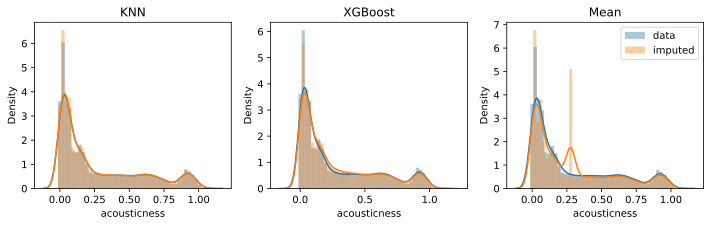

In [54]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.distplot(tt[FEATURES].acousticness, ax=ax[0], label="data")
sns.distplot(knn_imputed_df.acousticness, ax=ax[0], label="imputed")
ax[0].set_title("KNN")

sns.distplot(tt[FEATURES].acousticness, ax=ax[1], label="data")
sns.distplot(xgb_imputed_df.acousticness, ax=ax[1], label="imputed")
ax[1].set_title("XGBoost")

sns.distplot(tt[FEATURES].acousticness, ax=ax[2], label="data")
sns.distplot(tt_simple_imputed.acousticness, ax=ax[2], label="imputed")
ax[2].set_title("Mean")
ax[2].legend();

KNN follows the existing distribution most closely, while XGBoost imputation allows for a little variation (which may be desirable). For the simple imputer, all imputed data concentrates on a single point which here is the mean of the known values. In general, its better to use median imputer for skewed distributions (a few extreme values can bias the mean).

## What imputer to choose?

Test on your cross-validation folds! Always test everything in your cross-validation scheme and choose the best method. Not necessarily what you think is the most complicated. The philosophy is that since the dataset is too complex, there no straightforward way to know *a priori* which method will work best, so we take an experimental approach. GM Bojan Tunguz expresses this nicely in [his blog post](https://medium.com/@tunguz/about-those-transformers-for-tabular-data-116c13c36a5c) about [transformers for tabular data](https://keras.io/examples/structured_data/tabtransformer/):

> There is a tendency in certain parts of the ML world to equate technical virtuosity with the quality of ML modeling. Unfortunately, this ethos is especially prevelant (*sic*) in the cautting (*sic*) edge tech sector. It cannot be emphasized strongly enough that this is a misguided attitude at best, and can lead to downright inferior models [...].
